###NLP Homework 10
####Submitted By- Srashti Soni

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

import seaborn as sns
sns.set(style = 'white')
from nltk import FreqDist


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# load the data
df = pd.read_csv("/content/sample_data/imdb-reviews_2.csv")
df.head()

,review,label
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [ ]:
# Count the number of positive and negative sentiment
df_count = pd.DataFrame(df['label'].value_counts()).reset_index()
df_count.columns = ['label', 'Count'] 
df_count['label'] = df_count['label'].map({1 : 'Positive', 0: 'Negative'}) 
df_count

,label,Count
0,Positive,2528
1,Negative,2472


In [ ]:
# Clean the text ‘review’ and create a column called ‘review_processed’
df['review_processed'] = df['review'].str.replace("[^a-zA-Z#]", " ") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# Re ordering columns
df = df[['review','review_processed','label']]
df.head()

,review,review_processed,label
0,"first think another Disney movie, might good, ...",first think another Disney movie might good ...,1
1,"Put aside Dr. House repeat missed, Desperate H...",Put aside Dr House repeat missed Desperate H...,0
2,"big fan Stephen King's work, film made even gr...",big fan Stephen King s work film made even gr...,1
3,watched horrid thing TV. Needless say one movi...,watched horrid thing TV Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,truly enjoyed film acting terrific plot Jeff...,1


In [ ]:
# Replace short words
df['review_processed'] = df['review_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [ ]:
# Make entire text lowercase
df['review_processed'] = [review.lower() for review in df['review_processed']]

In [ ]:
# Remove stopwords
stop_words = stopwords.words('english')

# Make custom list of words to be removed including ‘movie’, ‘film’, ‘one’, ‘make’,and ‘even’ 
custom_list = ['movie','film','one','make','even']

# Adding to the above list of words
stop_words.extend(custom_list)

# function for removing stopwords
def remove_stopwords(rev):
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

# Removing stopwords
df['review_processed'] = [remove_stopwords(r) for r in df['review_processed']]

In [ ]:
# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag
def tag_to_wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df['review_processed'] = df['review_processed'].apply(lambda x: lemmatize_sentence(x))

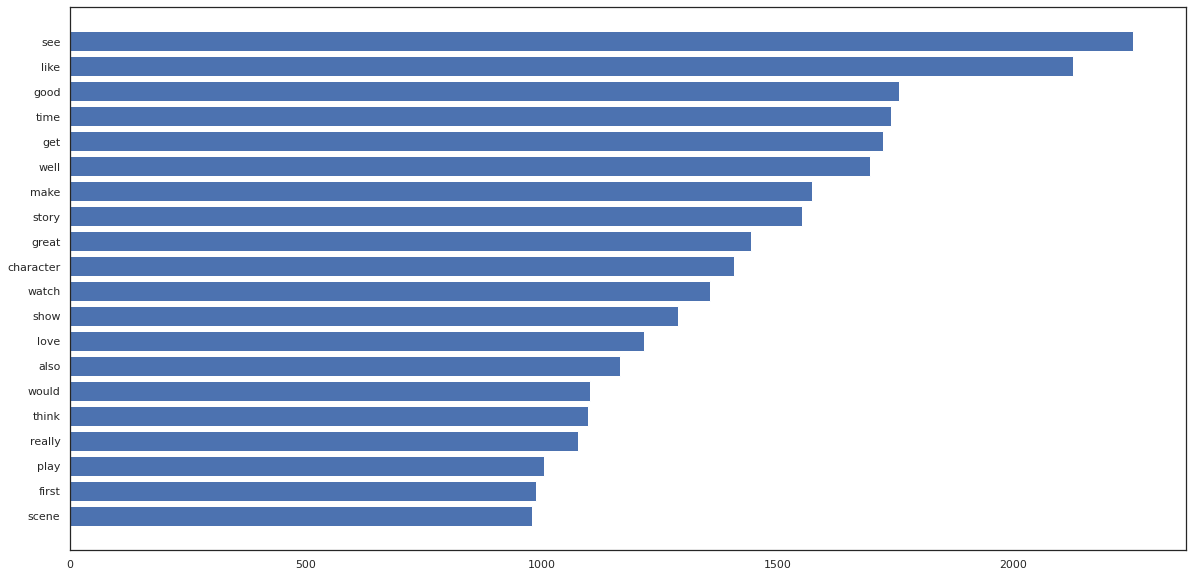

In [ ]:
# Plot the most frequent words from positive reviews using bar chart. Subset positive review dataset, extract words into list and count frequency. Subset top 30 words by frequency in a horizontal bar chart

# Subset positive review dataset
all_words_df = df[df['label'] == 1]

# Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df ['review_processed']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})

# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,10))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

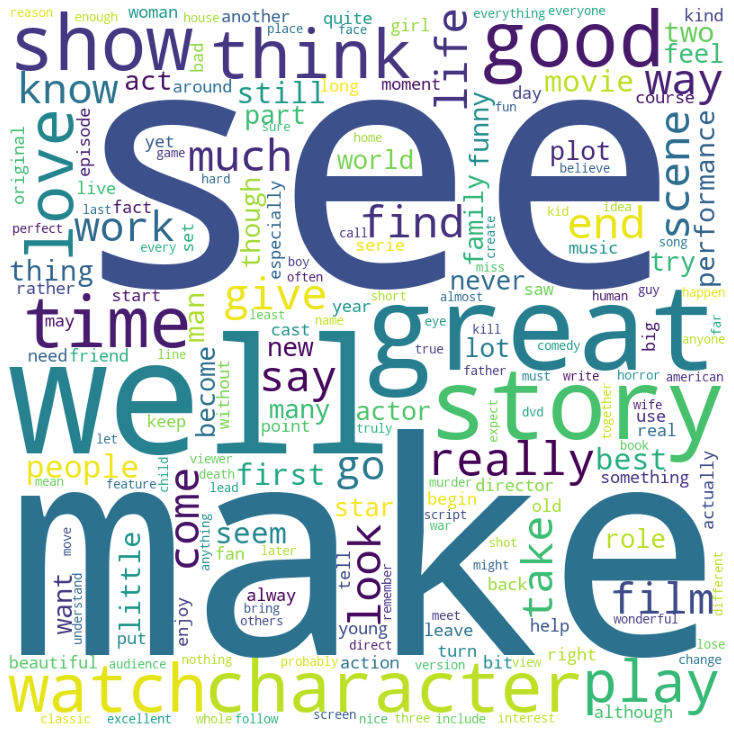

In [ ]:
# Create a word cloud
from wordcloud import WordCloud
word_cloud_df = df[df['label'] == 1]
all_words = ' '.join([text for text in word_cloud_df['review_processed']])
 

word_cloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
# Import CountVectorizer and create a sparse matrix of 2,500 tokens. Split the data set into train and test (20%) set
from sklearn.feature_extraction.text import CountVectorizer

# Creating sparse matrix of top 2500 tokens
count_vec = CountVectorizer(max_features = 2500)
X = count_vec.fit_transform(df.review_processed).toarray()
y = df.label.values

# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
# Use the GaussianNB to train the model on the training data. Provide the accuracy of the model
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

## Testing the model on test set
y_pred = classifier.predict(X_test)

In [ ]:
# Create the confusion marix and classification report
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[416 101]
 [176 307]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       517
           1       0.75      0.64      0.69       483

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



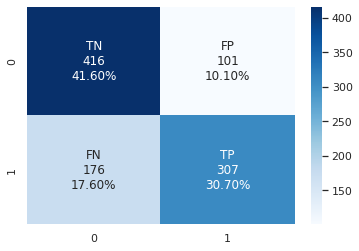

In [ ]:
# Use Seaborn heatmap to show TP, FP, TN, FN values

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

In [ ]:
# Use a logistic regression model and check the accuracy of the model for C=0.01,0.05, 0.5, 0.5, and 1
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : [0.01,0.05, 0.5, 0.5,1],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

clf.fit(X_train,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.05, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.833


Text(0, 0.5, 'True Positive Rate')

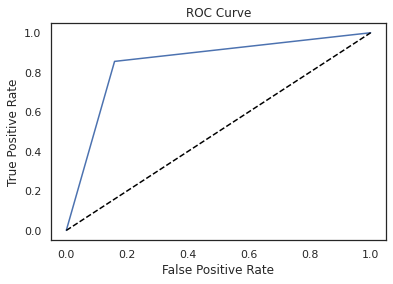

In [ ]:
# Provide the ROC curve. What is the area under the curve?
#ROC Curve
from sklearn.metrics import roc_curve

y_test_pred_probs= clf.predict(X_test)

FPR, TPR, _ = roc_curve(y_test,y_test_pred_probs )

#plotting the values using matplotlib
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### What is the area under the curve?
As we can clearly see that the AUC is 0.9 which is close to 1, hence it can be concluded that the classification model is a good fit and has a good measure of separability which means the model is reciprocating accurately.